In [4]:
import copy
import sys

import einops
import numpy
import numpy as np
import torch

sys.exc_info()
from utils.config import process_config
from datasets.sleepset import *
from graphs.models.attention_models.windowFeature_base import *
from sklearn.metrics import f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from utils.deterministic_pytorch import deterministic
# import umap
from scipy.stats import entropy
import os
from torchdistill.core.forward_hook import ForwardHookManager
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import pandas as pd
%config InlineBackend.figure_format = 'retina'

In [3]:
def sleep_load_encoder(encoders):
    encs = []
    for num_enc in range(len(encoders)):
        if encoders[num_enc]["model"] == "TF":
            layers = ["huy_pos_inner", "inner_att", "aggregation_att_contx_inner", "huy_pos_outer", "outer_att"]
            enc = Multi_Transformer(128, inner= 29, outer = 21, modalities=1, heads=8,
                                 layers = layers, num_layers=4, pos = False)
        else:
            enc_class = globals()[encoders[num_enc]["model"]]
            args = encoders[num_enc]["args"]
            enc = enc_class(args = args)
            enc = nn.DataParallel(enc, device_ids=[torch.device(0)])

        if encoders[num_enc]["pretrainedEncoder"]["use"]:
            print("Loading encoder from {}".format(encoders[num_enc]["pretrainedEncoder"]["dir"]))
            checkpoint = torch.load(encoders[num_enc]["pretrainedEncoder"]["dir"])
            enc.load_state_dict(checkpoint["encoder_state_dict"])
        encs.append(enc)
    return encs

def load_models(config, device, checkpoint, only_model=False):

    model_class = globals()[config.model.model_class]
    # config.pretrainedEncoder = [False]
    enc = sleep_load_encoder(encoders=config.model.encoders)
    model = model_class(enc, args = config.model.args)
    # model = model.to('cpu')
    # model = nn.DataParallel(model, device_ids='cpu')
    model = model.to(device)
    model = nn.DataParallel(model, device_ids=[torch.device(i) for i in config.gpu_device])
    # print(device)
    # model = nn.DataParallel(model, device="cpu")

    #
    if only_model:
        return model

    # config.pretrainedEncoder = [True]
    # enc = sleep_load_encoder(encoder_models=config.encoder_models,pretrainedEncoder=config.pretrainedEncoder,save_dir_encoder=config.savetrainedEncoder)
    # best_model = model_class(enc, channel = config.channel)
    # best_model = best_model.to(device)
    # best_model = nn.DataParallel(best_model, device_ids=[torch.device(i) for i in config.gpu_device])

    best_model = copy.deepcopy(model)
    # best_model = best_model.to('cpu')
    # best_model = nn.DataParallel(best_model, device_ids='cpu')
    # model.load_state_dict(checkpoint["model_state_dict"])
    best_model.load_state_dict(checkpoint["best_model_state_dict"])

    return model, best_model

def find_patient_list(data_loader):
    patient_list = [int(data.split("/")[-1][1:5]) for data in data_loader.dataset.dataset[0] if data.split("/")[-1]!="empty"]
    return patient_list

def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)):
        if y_actual[i] == y_hat[i] == 1:
            TP += 1
        if y_hat[i] == 1 and y_actual[i] != y_hat[i]:
            FP += 1
        if y_actual[i] == y_hat[i] == 0:
            TN += 1
        if y_hat[i] == 0 and y_actual[i] != y_hat[i]:
            FN += 1

    return (TP, FP, TN, FN)

def print_perf(model_name, patient_num, preds, tts, multiclass=True):
    preds_eeg = preds.argmax(-1)
    test_acc = np.equal(tts, preds_eeg).sum() / len(tts)
    test_f1 = f1_score(preds_eeg, tts) if not multiclass else f1_score(preds_eeg, tts, average="macro")
    test_perclass_f1 = f1_score(preds_eeg, tts) if not multiclass else f1_score(preds_eeg, tts, average=None)
    test_k = cohen_kappa_score(tts, preds_eeg)
    test_auc = roc_auc_score(tts, preds_eeg) if not multiclass else 0
    test_conf = confusion_matrix(tts, preds_eeg)
    tp, fp, tn, fn = perf_measure(tts, preds_eeg)
    test_spec = tn / (tn + fp) if (tn + fp) != 0 else 0
    test_sens = tp / (tp + fn) if (tp + fn) != 0 else 0
    print("{} Patient {} has acc: {}, f1: {}, k:{} and f1_per_class: {}".format(model_name, patient_num,
                                                                             round(test_acc * 100, 1),
                                                                             round(test_f1 * 100, 1),
                                                                             round(test_k, 3),
                                                                             np.round(test_perclass_f1 * 100,
                                                                                      1)))
    return test_k

def get_performance_windows(preds, tts, print_it=True, window=40, type="f1"):
    tts_unfolded = torch.from_numpy(tts).unfold(0, window, window).numpy()
    preds_unfolded = torch.from_numpy(preds).unfold(0, window, window).numpy()
    if type == "accuracy":
        perf_window = np.array([np.equal(tts_unfolded[i], preds_unfolded[i]).sum() / len(tts_unfolded[i]) for i in range(tts_unfolded.shape[0])])
    elif type=="k":
        perf_window = np.array([cohen_kappa_score(tts_unfolded[i], preds_unfolded[i]) for i in range(tts_unfolded.shape[0])])
    elif type=="f1":
        perf_window = np.array([f1_score(tts_unfolded[i], preds_unfolded[i], average="macro") for i in range(tts_unfolded.shape[0])])
    else:
        raise ValueError("This type of performance does not extst, 'accuracy', 'k' and 'f1'")
    perf_window[perf_window != perf_window] = 1
    if print_it:
        for i in perf_window: print("{:.3f}".format(i), end=" ")
        print()
    perf_window = perf_window
    return perf_window
def get_windows(input, window=40):
    input_unfolded = torch.from_numpy(input).unfold(0, window, window).numpy()
    if (input_unfolded != input_unfolded).any(): print("Τhere are nan")
    input_unfolded = input_unfolded.mean(axis=-1)
    # input_unfolded = input_unfolded.repeat(window)
    return input_unfolded

def change_numbers_preds(preds, tts, argmax=True):
    if argmax: pred_plus = copy.deepcopy(preds).argmax(-1)
    else: pred_plus = copy.deepcopy(preds)
    pred_plus[pred_plus == 4] = 5
    pred_plus[pred_plus == 3] = 4
    pred_plus[pred_plus == 2] = 3
    pred_plus[pred_plus == 5] = 2

    target_plus = copy.deepcopy(tts)
    target_plus[target_plus == 4] = 5
    target_plus[target_plus == 3] = 4
    target_plus[target_plus == 2] = 3
    target_plus[target_plus == 5] = 2

    return pred_plus, target_plus

def find_matches(pred_plus, target_plus):

    non_matches = (pred_plus != target_plus).astype(int)
    non_matches_idx = non_matches.nonzero()[0]
    return non_matches_idx

def print_max_perf(predictors, performs, tts, window_floor):
    max_preds = []
    for i in range(len(performs[0])):
        max_mod = np.argmax(np.array([perf[i] for perf in performs]))
        max_preds.append(predictors[max_mod][i*window_floor:(i+1)*window_floor])
    max_preds = np.array(max_preds).flatten()

    multiclass = True
    model_name = "Max"
    test_acc = np.equal(tts, max_preds).sum() / len(tts)
    test_f1 = f1_score(max_preds, tts) if not multiclass else f1_score(max_preds, tts, average="macro")
    test_perclass_f1 = f1_score(max_preds, tts) if not multiclass else f1_score(max_preds, tts, average=None)
    test_k = cohen_kappa_score(tts, max_preds)
    test_auc = roc_auc_score(tts, max_preds) if not multiclass else 0
    test_conf = confusion_matrix(tts, max_preds)
    tp, fp, tn, fn = perf_measure(tts, max_preds)
    test_spec = tn / (tn + fp) if (tn + fp) != 0 else 0
    test_sens = tp / (tp + fn) if (tp + fn) != 0 else 0
    print("{} Patient {} has acc: {}, f1: {}, k:{} and f1_per_class: {}".format(model_name, patient_num,
                                                                             round(test_acc * 100, 1),
                                                                             round(test_f1 * 100, 1),
                                                                             round(test_k, 3),
                                                                             np.round(test_perclass_f1 * 100,
                                                                                      1)))
    return test_k, max_preds

print("Done Loading")

Done Loading


In [5]:
multimodal_config_name = "./configs/shhs/multi_modal/eeg_eog/established_models/fourier_transformer_eeg_eog_mat_BIOBLIP_lossw.json"

multimodal_config = process_config(multimodal_config_name, False)

multimodal_config.data_view_dir = [
            {"list_dir" : "patient_mat_list.txt", "data_type": "stft", "mod": "eeg", "num_ch": 1},
            {"list_dir" :"patient_eog_mat_list.txt", "data_type": "stft", "mod": "eog", "num_ch": 1},
            {"list_dir" :"patient_emg_mat_list.txt", "data_type": "stft", "mod": "emg", "num_ch": 1},
            {"list_dir" : "patient_mat_list.txt", "data_type": "time", "mod": "eeg", "num_ch": 1},
            {"list_dir" : "patient_eog_mat_list.txt", "data_type": "time", "mod": "eog", "num_ch": 1},
            {"list_dir" : "patient_emg_mat_list.txt", "data_type": "time", "mod": "emg", "num_ch": 1}
        ]

In [6]:
device = "cuda:0"
# device = "cpu"
multimodal_config.test_batch_size=128
#Load the models
checkpoint_multimodal = torch.load(multimodal_config.model.save_dir, map_location="cpu")
dataloader = globals()[multimodal_config.dataloader_class]
data_loader = dataloader(config=multimodal_config)
data_loader.load_metrics_ongoing(checkpoint_multimodal["metrics"])
data_loader.weights = checkpoint_multimodal["logs"]["weights"]

_, best_model_multimodal = load_models(config=multimodal_config, device=device, checkpoint=checkpoint_multimodal)

We are splitting dataset by huy splits
True
We are loading weights
[0. 0. 0. 0. 0.]


In [22]:
plt.style.use('ggplot')

best_model_multimodal.eval()

data_loader_subset = data_loader.test_loader
patient_list = find_patient_list(data_loader=data_loader_subset)
patient_list = [2, 55, 91, 23, 40]
# patient_list = [177, 885, 2783]
# patient_list = patient_list[:10]
which_patient = 0
bad_performing_patients = []
bad_performing_windows= 0
good_performing_windows= 0
total_performing_windows= 0
tts, preds, matches, inits, views_eeg, views_eog, views_emg, inter_eeg, inter_eog = [], [], [], [], [], [], [], [], []
views_eeg_time, views_eog_time, views_emg_time = [], [], []
router_std_preds, std_choices = [], []
preds_eeg, preds_eog, preds_emg = [], [], []
with torch.no_grad():
    for i, patient_num in enumerate(patient_list):
        #Copy to keep dataset full size,
        this_data_loader = copy.deepcopy(data_loader_subset)
        this_data_loader.dataset.choose_specific_patient(patient_num)
        for batch_idx, (data, target, init, _) in enumerate(this_data_loader):
            views = [data[i].float().to(device) for i in range(len(data))]
            label = target.to(device)
            output = best_model_multimodal(views, return_inter_reps=True)
            print(output["inter_reps"][0].shape)
            tts.append(label)
            preds.append(output["preds"]["combined"].cpu())
            inter_eeg.append(output["inter_reps"][0].cpu())
            inter_eog.append(output["inter_reps"][1].cpu())

            # views_eeg.append(data[0])
            # views_eog.append(data[1])
            # views_emg.append(data[2])
            # views_eeg_time.append(views[3])
            # views_eog_time.append(views[4])
            # views_emg_time.append(views[5])


tts = torch.cat(tts).cpu().numpy().flatten()
preds = torch.cat(preds).cpu().numpy()
inter_eeg = torch.cat(inter_eeg).flatten(start_dim=0, end_dim=1).flatten(start_dim=1).cpu().numpy()
inter_eog = torch.cat(inter_eog).flatten(start_dim=0, end_dim=1).flatten(start_dim=1).cpu().numpy()


torch.Size([32, 21, 1, 1, 1, 128])
torch.Size([41, 21, 1, 1, 1, 128])
torch.Size([50, 21, 1, 1, 1, 128])
torch.Size([45, 21, 1, 1, 1, 128])
torch.Size([45, 21, 1, 1, 1, 128])


In [23]:
tts_p = tts[0:32*21]
preds_p = preds[0:32*21]
inter_eeg_p = inter_eeg[0:32*21]
inter_eog_p = inter_eog[0:32*21]

(-0.5, 4.5)

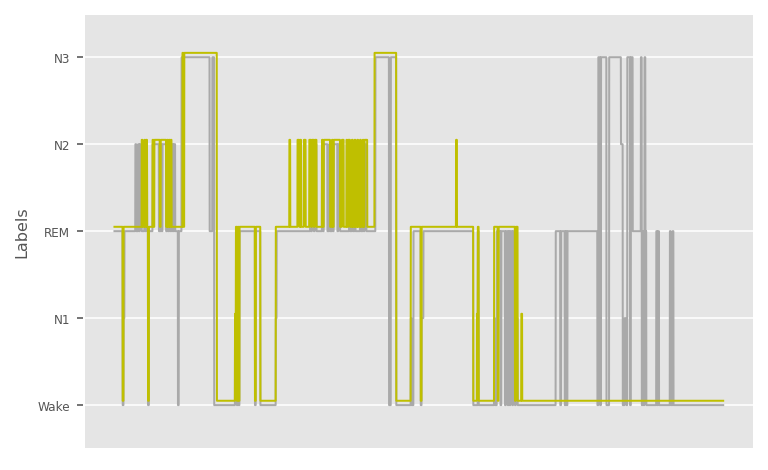

(-0.5, 4.5)

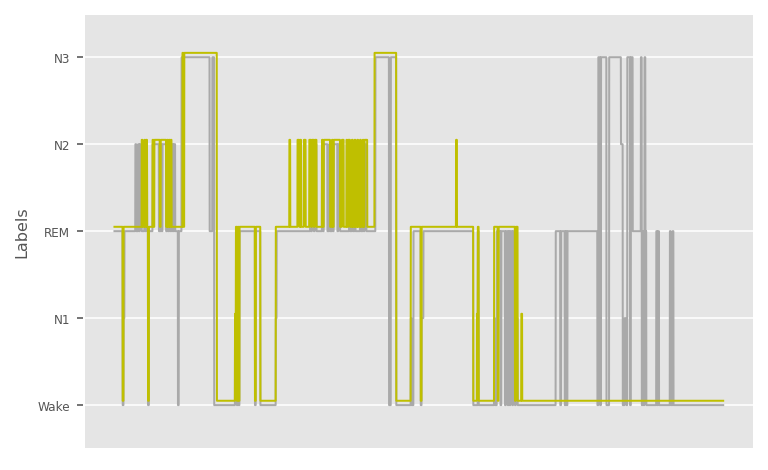

In [31]:
width_param = 10
plt.plot(preds_p.argmax(-1).repeat(width_param), label="Prediction", color="darkgray", linewidth=1)
plt.plot((tts_p+ 0.05).repeat(width_param), label="True Label", color="y", linewidth=1)
# for i in non_matches_idx: plt.axvspan(i*width_param, (i+1)*width_param, color="r", alpha=0.2)

# plt.scatter(non_matches_idx, pred_plus_hour[non_matches_idx], marker='*', edgecolors="r", label="Mistakes", linewidth=0.6)
plt.yticks([0, 1, 2, 3, 4], labels=["Wake", "N1", "REM", "N2", "N3"])
plt.xticks([])
# plt.xlim(0,len(preds_p.repeat(width_param))-1)
# for i in range(0, len(pred_plus_hour)):plt.axvline(x = width_param*i, color = 'gray', linewidth=0.15)
plt.yticks(fontsize=6)
plt.ylabel("Labels", fontsize=8)
plt.ylim(-0.5,4.5)
# plt.title("Patient {}, time {}-{} mins".format(patient_num, int(0/2), int(/2)), fontsize=10)

In [32]:
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns

X_embedded_eeg = TSNE(n_components=2,
                  perplexity=30.0,
                  early_exaggeration=12.0, learning_rate=100.0, n_iter=1000,
                  n_iter_without_progress=300, min_grad_norm=1e-7,
                  metric="euclidean",
                  init='random').fit_transform(inter_eeg_p.astype(float))

[Text(0.5, 1.0, 'EEG SHHS Val data T-SNE projection')]

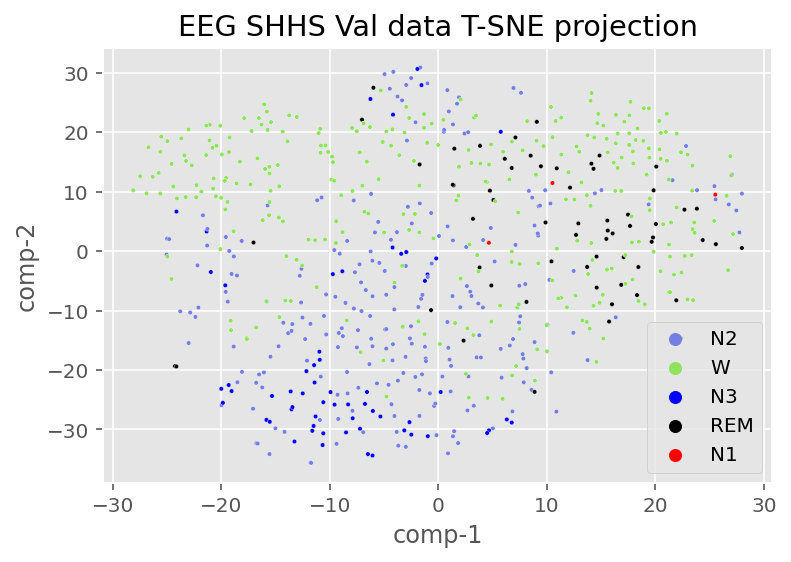

In [33]:
df = pd.DataFrame()
# df["y"] = tts_p==preds_p.argmax(-1)
df["y"] = tts_p
df["comp-1"] = X_embedded_eeg[:,0]
df["comp-2"] = X_embedded_eeg[:,1]

a = []
for i in df.y.tolist():
    if i==0: a.append("W")
    if i==1: a.append("N1")
    if i==2: a.append("N2")
    if i==3: a.append("N3")
    if i==4: a.append("REM")

colors = ['#747FE3', '#8EE35D', '#0000FF', '#000000', '#FF0000']

sns.scatterplot(x="comp-1", y="comp-2", hue=a,
                palette=colors[0:5], s=5,
                data=df).set(title="EEG SHHS Val data T-SNE projection")

[Text(0.5, 1.0, 'EEG SHHS Val data T-SNE projection')]

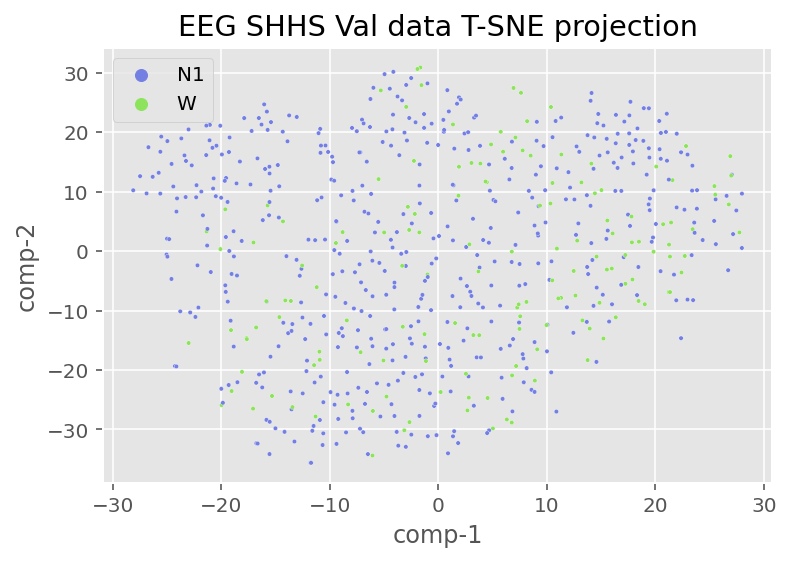

In [34]:
df = pd.DataFrame()
df["y"] = tts_p==preds_p.argmax(-1)
# df["y"] = tts_p
df["comp-1"] = X_embedded_eeg[:,0]
df["comp-2"] = X_embedded_eeg[:,1]

a = []
for i in df.y.tolist():
    if i==0: a.append("W")
    if i==1: a.append("N1")
    if i==2: a.append("N2")
    if i==3: a.append("N3")
    if i==4: a.append("REM")

colors = ['#747FE3', '#8EE35D', '#0000FF', '#000000', '#FF0000']

sns.scatterplot(x="comp-1", y="comp-2", hue=a,
                palette=colors[0:2], s=5,
                data=df).set(title="EEG SHHS Val data T-SNE projection")

In [ ]:
X_embedded_eog = TSNE(n_components=2,
                  perplexity=5.0,
                     early_exaggeration=12.0, learning_rate=100.0, n_iter=250,
                     n_iter_without_progress=300, min_grad_norm=1e-7,
                     metric="euclidean",
                  init='random').fit_transform(inter_eog_p.astype(float))

In [ ]:
df = pd.DataFrame()
df["y"] = tts_p==preds_p.argmax(-1)
df["comp-1"] = X_embedded_eog[:,0]
df["comp-2"] = X_embedded_eog[:,1]

a = []
for i in df.y.tolist():
    if i==0: a.append("W")
    if i==1: a.append("N1")
    if i==2: a.append("N2")
    if i==3: a.append("N3")
    if i==4: a.append("REM")

colors = ['#747FE3', '#8EE35D', '#0000FF', '#000000', '#FF0000']
sns.scatterplot(x="comp-1", y="comp-2", hue=a,
                palette=colors[:2], s=5,
                data=df).set(title="EOG SHHS Val data T-SNE projection")

In [ ]:
print(np.unique(np.array(a),return_counts=True))